In [22]:
import matplotlib
from spectral.io import envi
import numpy as np
import numpy.ma as ma
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib ipympl
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools
from scipy.ndimage import gaussian_filter
from ipywidgets import interact, fixed
from mpl_interactions import ipyplot as iplt
from scipy.stats import pearsonr

def load_image_envi(waterfall_path):
    vnir_ds = envi.open(waterfall_path)
    vnir_profile = vnir_ds.metadata
    vnir_arr = vnir_ds.load()

    return vnir_arr, vnir_profile

def callback_CC(sdr, status):
    # Status indicates at which stage of the optimization we currently are
    # For now, we will only react at the end of each resolution of the scale
    # space
    if status == imwarp.RegistrationStages.SCALE_END:
        # get the current images from the metric
        wmoving = sdr.metric.moving_image
        wstatic = sdr.metric.static_image
        # draw the images on top of each other with different colors
        regtools.overlay_images(wmoving, wstatic, 'Warped moving', 'Overlay',
                                'Warped static')
        
def get_highest_corr_coeff(swir_patch, mica_patch):

    correllation_arr = np.zeros((swir_patch.shape[-1], mica_patch.shape[-1]))

    # Loop through each band in SWIR and Mica
    for i in range(swir_patch.shape[2]):  # Assuming the number of bands is in the third dimension
        for j in range(mica_patch.shape[2]):  # Assuming the number of bands is in the third dimension
            # Calculate correlation coefficient using sampled data
            correlation, _ = pearsonr(swir_patch[...,i].flatten(), mica_patch[...,j].flatten())
            correllation_arr[i,j] = correlation


    highest_corr_ind = np.unravel_index(np.argmax(correllation_arr), correllation_arr.shape)
    highest_corr = correllation_arr[highest_corr_ind]

    return list(highest_corr_ind), highest_corr
        
def update_parameters(step_length,
                      levels_iters_1,
                      levels_iters_2,
                      inv_iter,
                      scale_space_smoothing_kernel,
                      optimization_tol,
                      metric_sigma,
                      metric_radius):
    metric = CCMetric(2, metric_sigma, metric_radius)
    sdr = SymmetricDiffeomorphicRegistration(metric=metric,
                                     step_length=step_length,
                                     level_iters=[int(levels_iters_1),int(levels_iters_2)],
                                     inv_iter=int(inv_iter),
                                     ss_sigma_factor=scale_space_smoothing_kernel,
                                     opt_tol=optimization_tol)

    mapping = sdr.optimize(mica_patch_lpf, swir_patch_lpf)
    swir_patch_warped = mapping.transform(swir_patch)
    return swir_patch_warped


SWIR B112 with Mica B2. Pearson's correllation coefficient: 0.8973


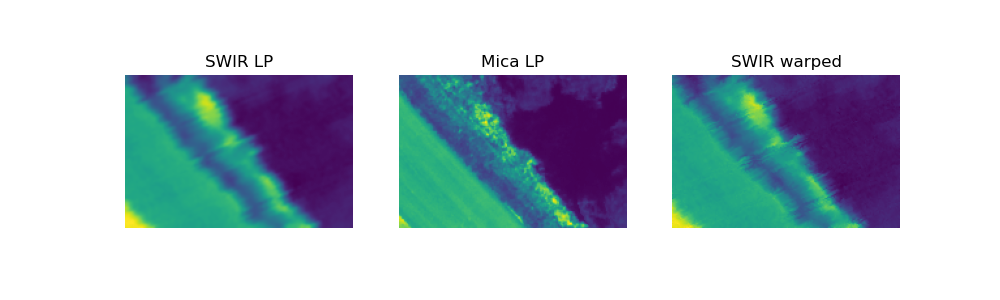

In [23]:
 # load the SWIR image and select band 38
or_hdr = "/Volumes/T7/axhcis/Projects/NURI/data/20210723_tait_labsphere/1133/SWIR/raw_1504_nuc_or_plusindices3.hdr"
swir_arr, swir_profile= load_image_envi(or_hdr)
swir_patch = swir_arr[1064:1181, 493:668].squeeze()

# load the micasense and select last band
mica_hdr = "/Volumes/T7/axhcis/Projects/NURI/data/20210723_tait_labsphere/1133/Micasense/NURI_micasense_1133_transparent_mosaic_stacked_warped.hdr"
mica_arr, mica_profile = load_image_envi(mica_hdr)
mica_patch = mica_arr[2655:2772, 812:987].squeeze()


# performing correllation coefficient between the two to pick the highest
highest_corr_ind, highest_corr = get_highest_corr_coeff(swir_patch, mica_patch)
swir_patch = swir_patch[..., highest_corr_ind[0]]
mica_patch = mica_patch[..., highest_corr_ind[1]]
print(f"SWIR B{highest_corr_ind[0]} with Mica B{highest_corr_ind[1]}. Pearson's correllation coefficient: {highest_corr:.4f}")

# Running low pass filter on the swir patch to minimize the
swir_patch_lpf = gaussian_filter(swir_patch, sigma=1)
mica_patch_lpf = gaussian_filter(mica_patch, sigma=0)

fig, ax = plt.subplots(1,3, figsize = (10,3))
ax = ax.flatten()
ax[0].imshow(swir_patch_lpf)
ax[0].axis("off")
ax[0].set_title("SWIR LP")
ax[1].imshow(swir_patch_lpf)
ax[1].axis("off")
ax[1].set_title("SWIR LP")
ax[2].imshow(mica_patch_lpf)
ax[].axis("off")
ax[1].set_title("Mica LP")
ax[2].axis("off")
ax[2].set_title("SWIR warped")


controls = iplt.imshow(update_parameters, 
                       step_length = (1,10),
                      levels_iters_1 = (1,200),
                      levels_iters_2 = (1,200),
                      inv_iter = (1,200),
                      scale_space_smoothing_kernel = (0.1,10),
                      optimization_tol = (0.001,10),
                      metric_sigma = (1,10),
                      metric_radius= (1,10),
                      ax=ax[2])

